In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import util
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tqdm import tqdm 
import warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Number of clusters (excl. outliers)
k = 4

# Points per cluster (excl. outliers)
n = [500] * k

# Number of dimensions
d = 100

# Number of outliers
o = 50

# Cluster sizes
cluster_sizes = n + [o]

# Total clusters
k_total = k + (1 if o > 0 else 0)

In [3]:
"""
Generate cluster centers
"""

# Scaling factor
alpha = 5

x = np.empty((0, d))

# C1 = first half 0, second half 1
half = np.zeros((1, ((3 * d) // 5))) + 0.1
half2 = np.zeros((1, d - ((3 * d) // 5))) + 1.1
x = np.vstack((x, np.hstack((half, half2))))

# C2 = first half 0.25, second half 0.75
half = np.zeros((1, d // 2)) + 0.25
half2 = np.zeros((1, d // 2)) + 0.75
x = np.vstack((x, np.hstack((half, half2))))

# C3 = first half 1, second half 0
half = np.zeros((1, d // 2)) + 1
half2 = np.zeros((1, d // 2))
x = np.vstack((x, np.hstack((half, half2))))

# C4 = first third 0.8, second third 0.2, last third 0.6
one = np.zeros((1, d//3)) + 0.8 
two = np.zeros((1, d//3)) + 0.2
three = np.zeros((1, (d - 2*(d//3)))) + 0.6
x = np.vstack((x, np.hstack((one, two, three))))

x = x * 5

# Assert size and full rank
assert x.shape == (k, d)
assert np.linalg.matrix_rank(x) == k

In [4]:
noise_levels = [(0.3, 0.5), (1.5, 2), (3, 4)]

name_dict = {
    0: 'Low noise',
    1: 'Medium noise',
    2: 'High noise'
}

results = {
    'Low noise': tuple(),
    'Medium noise': tuple(),
    'High noise': tuple() 
}

pca_dim = 4

for idx, noise in enumerate(noise_levels):
    Y = util.generate_points(x, d, n, k, noise[0], noise[1])
    Y = util.generate_doublet_outliers(o, cluster_sizes, Y)
    Y = np.log1p(Y - min(0, np.min(Y)) + 1)
    outlier_idx = set([i for i in range(sum(n), sum(cluster_sizes))])
    
    # Compressibility approach
    C = util.get_compression_matrix(Y, pca_dim, False, True)
    var_list = util.variance_list(C)
    compression_res = 0
    for i in range(o): 
        if var_list[i][1] in outlier_idx:
            compression_res += 1

    Y_pca = PCA(n_components=pca_dim).fit_transform(Y)
    # LOF approach
    lof = util.lof(Y_pca)
    lof_res = 0
    for i in range(o):
        if int(lof[i][1]) in outlier_idx:
            lof_res += 1

    # ECOD approach
    ecod = util.ecod(Y_pca)
    ecod_res = 0
    for i in range(o):
        if int(ecod[i][1]) in outlier_idx:
            ecod_res += 1
    
    # KNN-dist approach
    knn_dist = util.KNN_dist(Y_pca, 20)
    knn_dist_res = 0
    for i in range(o):
        if int(knn_dist[i][1]) in outlier_idx:
            knn_dist_res += 1
    
    results[name_dict[idx]] += (compression_res,lof_res,ecod_res,knn_dist_res)

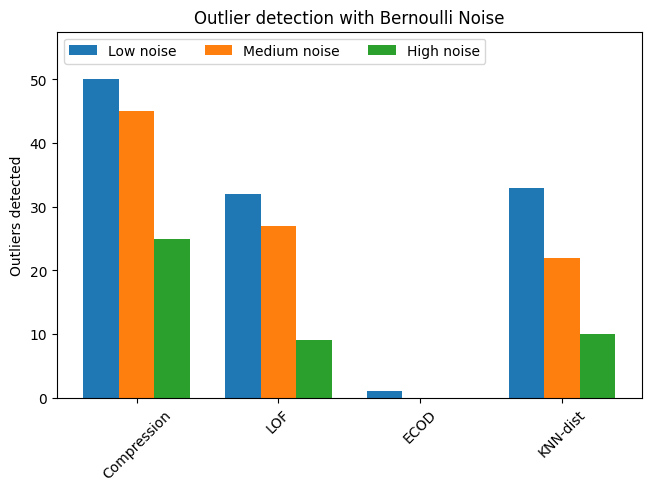

In [5]:
util.multi_bar_graph(["Compression", "LOF", "ECOD", "KNN-dist"], results, "Outlier detection with Bernoulli Noise", "Outliers detected")

In [6]:
results_uniform = {
    'Low noise': tuple(),
    'Medium noise': tuple(),
    'High noise': tuple() 
}

for idx, noise in enumerate(noise_levels):
    Y = util.generate_points(x, d, n, k, noise[0], noise[1], method='uniform')
    Y = util.generate_doublet_outliers(o, cluster_sizes, Y)
    Y = np.log1p(Y - min(0, np.min(Y)) + 1)
    outlier_idx = set([i for i in range(sum(n), sum(cluster_sizes))])
    
    # Compressibility approach
    C = util.get_compression_matrix(Y, pca_dim, False, True)
    var_list = util.variance_list(C)
    compression_res = 0
    for i in range(o): 
        if var_list[i][1] in outlier_idx:
            compression_res += 1

    Y_pca = PCA(n_components=pca_dim).fit_transform(Y)
    # LOF approach
    lof = util.lof(Y_pca)
    lof_res = 0
    for i in range(o):
        if int(lof[i][1]) in outlier_idx:
            lof_res += 1

    # ECOD approach
    ecod = util.ecod(Y_pca)
    ecod_res = 0
    for i in range(o):
        if int(ecod[i][1]) in outlier_idx:
            ecod_res += 1
    
    # KNN-dist approach
    knn_dist = util.KNN_dist(Y_pca, 20)
    knn_dist_res = 0
    for i in range(o):
        if int(knn_dist[i][1]) in outlier_idx:
            knn_dist_res += 1
    
    results_uniform[name_dict[idx]] += (compression_res,lof_res,ecod_res,knn_dist_res)

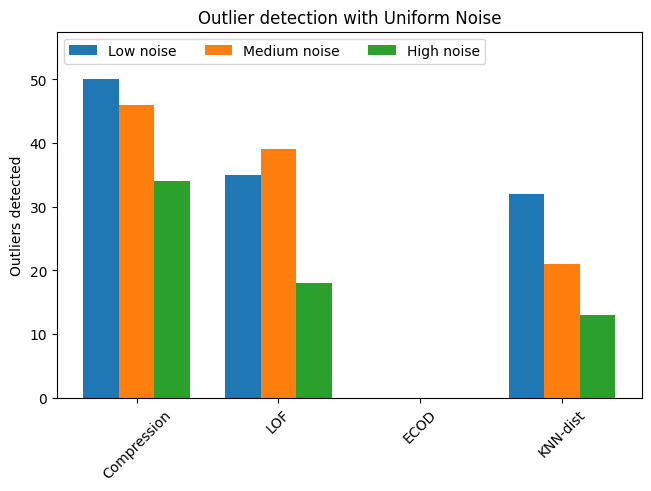

In [8]:
util.multi_bar_graph(["Compression", "LOF", "ECOD", "KNN-dist"], results_uniform, "Outlier detection with Uniform Noise", "Outliers detected")

In [18]:
results_scaled_var = {
    'c = 2': tuple(),
    'c = 4': tuple(),
    'c = 6': tuple() 
}

name_dict_scaled = {
    0: 'c = 2',
    1: 'c = 4',
    2: 'c = 6'
}

c_levels = [2, 4, 6]

for idx, val in enumerate(c_levels):
    bound = 10
    sigma = np.sqrt((bound ** 2) / 3) 
    Y = util.generate_points(x, d, n, k, bound, bound, method='uniform')
    Y = util.generate_outliers(o, x, sigma, val, Y, method='uniform')
    Y = np.log1p(Y - min(0, np.min(Y)) + 1)
    outlier_idx = set([i for i in range(sum(n), sum(cluster_sizes))])
    
    # Compressibility approach
    C = util.get_compression_matrix(Y, pca_dim, False, True)
    var_list = util.variance_list(C)
    compression_res = 0
    for i in range(o): 
        if var_list[i][1] in outlier_idx:
            compression_res += 1

    Y_pca = PCA(n_components=pca_dim).fit_transform(Y)
    # LOF approach
    lof = util.lof(Y_pca)
    lof_res = 0
    for i in range(o):
        if int(lof[i][1]) in outlier_idx:
            lof_res += 1

    # ECOD approach
    ecod = util.ecod(Y_pca)
    ecod_res = 0
    for i in range(o):
        if int(ecod[i][1]) in outlier_idx:
            ecod_res += 1
    
    # KNN-dist approach
    knn_dist = util.KNN_dist(Y_pca, 20)
    knn_dist_res = 0
    for i in range(o):
        if int(knn_dist[i][1]) in outlier_idx:
            knn_dist_res += 1
    
    results_scaled_var[name_dict_scaled[idx]] += (compression_res,lof_res,ecod_res,knn_dist_res)

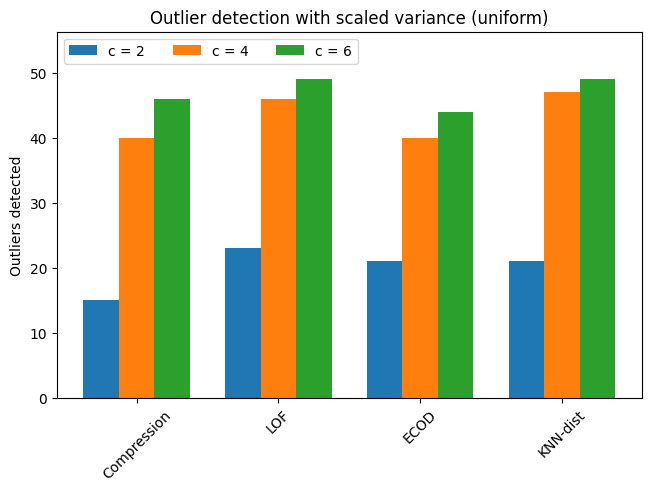

In [19]:
util.multi_bar_graph(["Compression", "LOF", "ECOD", "KNN-dist"], results_scaled_var, "Outlier detection with scaled variance (uniform)", "Outliers detected")

In [20]:
results_gauss_scaled = {
    'c = 2': tuple(),
    'c = 4': tuple(),
    'c = 6': tuple() 
}

c_levels = [2, 4, 6]

for idx, val in enumerate(c_levels):
    sigma = 10
    Y = util.generate_points(x, d, n, k, sigma, sigma, method='gaussian')
    Y = util.generate_outliers(o, x, sigma, val, Y, method='gaussian')
    Y = np.log1p(Y - min(0, np.min(Y)) + 1)
    outlier_idx = set([i for i in range(sum(n), sum(cluster_sizes))])
    
    # Compressibility approach
    C = util.get_compression_matrix(Y, pca_dim, False, True)
    var_list = util.variance_list(C)
    compression_res = 0
    for i in range(o): 
        if var_list[i][1] in outlier_idx:
            compression_res += 1

    Y_pca = PCA(n_components=pca_dim).fit_transform(Y)
    # LOF approach
    lof = util.lof(Y_pca)
    lof_res = 0
    for i in range(o):
        if int(lof[i][1]) in outlier_idx:
            lof_res += 1

    # ECOD approach
    ecod = util.ecod(Y_pca)
    ecod_res = 0
    for i in range(o):
        if int(ecod[i][1]) in outlier_idx:
            ecod_res += 1
    
    # KNN-dist approach
    knn_dist = util.KNN_dist(Y_pca, 20)
    knn_dist_res = 0
    for i in range(o):
        if int(knn_dist[i][1]) in outlier_idx:
            knn_dist_res += 1
    
    results_gauss_scaled[name_dict_scaled[idx]] += (compression_res,lof_res,ecod_res,knn_dist_res)

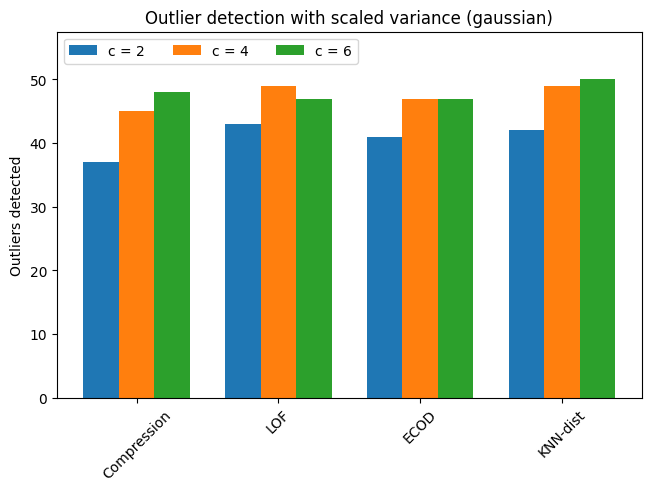

In [22]:
util.multi_bar_graph(["Compression", "LOF", "ECOD", "KNN-dist"], results_gauss_scaled, "Outlier detection with scaled variance (gaussian)", "Outliers detected")

In [12]:
results_doublet_center = {
    'Low noise': tuple(),
    'Medium noise': tuple(),
    'High noise': tuple() 
}

for idx, noise in enumerate(noise_levels):
    Y = util.generate_points(x, d, n, k, noise[0], noise[1], method='uniform')
    Y = util.generate_doublet_outliers_centers(o, x, Y, noise[1])
    Y = np.log1p(Y - min(0, np.min(Y)) + 1)
    outlier_idx = set([i for i in range(sum(n), sum(cluster_sizes))])
    
    # Compressibility approach
    C = util.get_compression_matrix(Y, pca_dim, False, True)
    var_list = util.variance_list(C)
    compression_res = 0
    for i in range(o): 
        if var_list[i][1] in outlier_idx:
            compression_res += 1

    Y_pca = PCA(n_components=pca_dim).fit_transform(Y)
    # LOF approach
    lof = util.lof(Y_pca)
    lof_res = 0
    for i in range(o):
        if int(lof[i][1]) in outlier_idx:
            lof_res += 1

    # ECOD approach
    ecod = util.ecod(Y_pca)
    ecod_res = 0
    for i in range(o):
        if int(ecod[i][1]) in outlier_idx:
            ecod_res += 1
    
    # KNN-dist approach
    knn_dist = util.KNN_dist(Y_pca, 20)
    knn_dist_res = 0
    for i in range(o):
        if int(knn_dist[i][1]) in outlier_idx:
            knn_dist_res += 1
    
    results_doublet_center[name_dict[idx]] += (compression_res,lof_res,ecod_res,knn_dist_res)

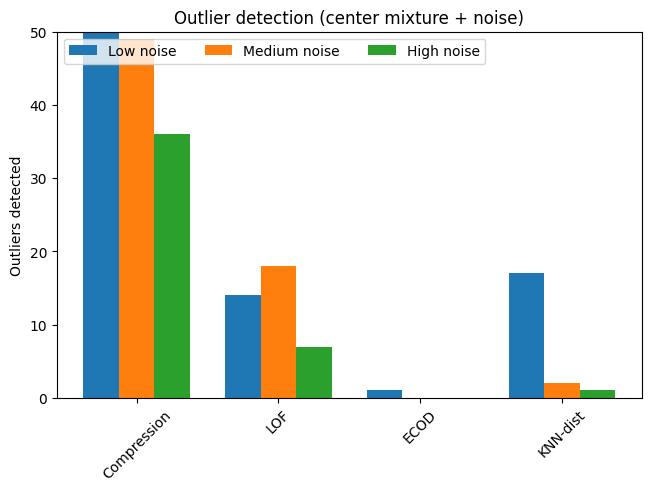

In [14]:
util.improvement_graph(["Compression", "LOF", "ECOD", "KNN-dist"], results_doublet_center, "Outlier detection (center mixture + noise)", "Outliers detected")

In [37]:
for idx, noise in enumerate(noise_levels): 
    Y = util.generate_points(x, d, n, k, noise[0], noise[1], method='uniform')
    labels = []
    for i in range(k):
        labels += [i] * n[i]
    labels = np.array(labels)
    Y, labels = util.generate_doublet_outliers_with_labels(o, cluster_sizes, Y, labels)
    Y = np.log1p(Y - min(0, np.min(Y)) + 1)

    combined = [(Y[i], labels[i]) for i in range(len(Y))]
    combined.sort(key=lambda x: x[1])
    Y = np.array([x[0] for x in combined])
    labels = np.array([x[1] for x in combined])

    adj_cluster_sizes = []
    for i in range(k):
        adj_cluster_sizes.append(sum(labels == i))
    
    _, inter, intra = util.get_compressibility(Y, adj_cluster_sizes, k, False, True)
    print(f"Inter-cluster compress: {inter}")
    print(f"Intra-cluster compress: {intra}")
    print()

Inter-cluster compress: [1.02394177 1.02713224 1.01116333 1.01941783]
Intra-cluster compress: [6.00986065 6.20100503 5.96170023 5.41674331]

Inter-cluster compress: [1.28099831 1.32201681 1.13576358 1.24630108]
Intra-cluster compress: [5.27938706 6.21224573 5.24611574 5.2983825 ]

Inter-cluster compress: [1.72849139 1.86240393 1.41837863 1.71293044]
Intra-cluster compress: [5.10588563 6.14636758 5.451863   5.24771928]



In [42]:
results_nmi_improvement = {
    'Low noise': tuple(),
    'Medium noise': tuple(),
    'High noise': tuple() 
}

for idx, noise in enumerate(noise_levels):
    Y = util.generate_points(x, d, n, k, noise[0], noise[1], method='uniform')
    labels = []
    for i in range(k):
        labels += [i] * n[i]
    labels = np.array(labels)
    Y, labels = util.generate_doublet_outliers_with_labels(o, cluster_sizes, Y, labels, upper_weight=0.55)
    Y = np.log1p(Y - min(0, np.min(Y)) + 1)

    combined = [(Y[i], labels[i]) for i in range(len(Y))]
    combined.sort(key=lambda x: x[1])
    Y = np.array([x[0] for x in combined])
    labels = np.array([x[1] for x in combined])

    adj_cluster_sizes = []
    for i in range(k):
        adj_cluster_sizes.append(sum(labels == i))

    # Baseline
    ari, nmi = util.pca_kmeans(Y, k, labels, k)
    print(f"Baseline NMI: {nmi}")
    print()

    # Compressibility approach
    ari_comp, nmi_comp = util.remove_pca_kmeans(Y, adj_cluster_sizes, labels, k, 0.1, False, None, 'compression')
    print(f"Compressibility NMI: {nmi_comp}")
    print()

    # LOF approach
    ari_lof, nmi_lof = util.remove_pca_kmeans(Y, adj_cluster_sizes, labels, k, 0.1, False, None, 'lof')
    print(f"LOF NMI: {nmi_lof}")
    print()

    # ECOD approach
    ari_ecod, nmi_ecod = util.remove_pca_kmeans(Y, adj_cluster_sizes, labels, k, 0.1, False, None, 'ecod')
    print(f"ECOD NMI: {nmi_ecod}")
    print()

    # KNN-dist approach
    ari_knn, nmi_knn = util.remove_pca_kmeans(Y, adj_cluster_sizes, labels, k, 0.1, False, None, 'knn')
    print(f"KNN-dist NMI: {nmi_knn}")
    print()

    results_nmi_improvement[name_dict[idx]] += (nmi_comp - nmi, nmi_lof - nmi, nmi_ecod - nmi, nmi_knn - nmi)

Baseline NMI: 0.9319742310182241

Compressibility NMI: 1.0

LOF NMI: 0.9488779025767993

ECOD NMI: 0.940558900422969

KNN-dist NMI: 0.9909941917809068

Baseline NMI: 0.9304414422292916

Compressibility NMI: 0.9842383515390855

LOF NMI: 0.9607488688401693

ECOD NMI: 0.9251705879590131

KNN-dist NMI: 0.9641626095287668

Baseline NMI: 0.9239859780575497

Compressibility NMI: 0.9398286789040937

LOF NMI: 0.9468122041822152

ECOD NMI: 0.91874577080881

KNN-dist NMI: 0.969841986194132



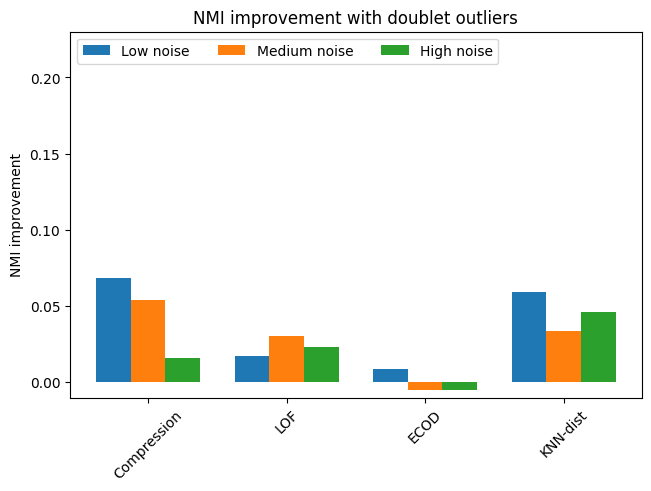

In [43]:
util.improvement_graph(["Compression", "LOF", "ECOD", "KNN-dist"], results_nmi_improvement, "NMI improvement with doublet outliers", "NMI improvement")